#  SBA LOAN Dataset

#### Please download the dataset from https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied as it is too large to include it in the submission. Place it into data/

In [405]:
# Importing Libraries
# Basic libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import datetime
import math
from datetime import date
from scipy import stats

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Imbalance Dataset
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
import scikitplot as skplt

# Modelling Algorithm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [406]:
# Load Data
df = pd.read_csv('../input/should-this-loan-be-approved-or-denied/SBAnational.csv').drop_duplicates()
print(df.head(10))
print('=' * 50)
print(df.info())
print('=' * 50)
print(df.isnull().sum())
print('=' * 50)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   LoanNr_ChkDgt                            Name            City State    Zip  \
0     1000014003                  ABC HOBBYCRAFT      EVANSVILLE    IN  47711   
1     1000024006     LANDMARK BAR & GRILLE (THE)       NEW PARIS    IN  46526   
2     1000034009           WHITLOCK DDS, TODD M.     BLOOMINGTON    IN  47401   
3     1000044001   BIG BUCKS PAWN & JEWELRY, LLC    BROKEN ARROW    OK  74012   
4     1000054004     ANASTASIA CONFECTIONS, INC.         ORLANDO    FL  32801   
5     1000084002  B&T SCREW MACHINE COMPANY, INC      PLAINVILLE    CT   6062   
6     1000093009   MIDDLE ATLANTIC SPORTS CO INC           UNION    NJ   7083   
7     1000094005                 WEAVER PRODUCTS     SUMMERFIELD    FL  34491   
8     1000104006                TURTLE BEACH INN  PORT SAINT JOE    FL  32456   
9     1000124001         INTEXT BUILDING SYS LLC     GLASTONBURY    CT   6073   

                            Bank BankState   NAICS ApprovalDate ApprovalFY  \
0               FIFTH THIRD BA

In [407]:
# Get the first two digits
def get_code(ind_code):
    if ind_code <= 0:
        return 0
    return (ind_code // 10 ** (int(math.log(ind_code, 10)) - 1))

# Use the two digits for the sector name
def sector_name(i):
    def_code = {11:'Agriculture, Forestry, Fishing & Hunting', 21:'Mining, Quarying, Oil & Gas',
                22:'Utilities', 23:'Constuction', 31:'Manufacturing', 32:'Manufacturing', 33:'Manufacturing',
                42:'Wholesale Trade', 44:'Retail Trade', 45:'Retail Trade', 48:'Transportation & Warehousing',
                49:'Transportation & Warehousing', 51:'Information', 52:'Finance & Insurance', 
                53:'Real Estate, Rental & Leasing', 54:'Professional, Scientific & Technical Service',
                55:'Management of Companies & Enterprise', 
                56:'Administrative, Support, Waste Management & Remediation Service',
                61:'Educational Service', 62:'Health Care & Social Assistance',
                71:'Arts, Entertainment & Recreation', 72:'Accomodation & Food Service',
                81:'Other Servieces (Ex: Public Administration)', 92:'Public Administration'
               }
    if i in def_code:
        return def_code[i]
    
def def_rate(i):
    sector_default = {21:0.08, 11:0.09, 55:0.10, 
                      62: 0.10, 22:0.14, 
                      92:0.15,54:0.19, 
                      42:0.19,31:0.19,
                      32:0.16,33:0.14,
                      81:0.20,71:0.21,
                      72:0.22,44:0.22,
                      45:0.23,23:0.23,
                      56:0.24,61:0.24,
                      51:0.25,48:0.27,
                      49:0.23,52:0.28,53:0.29}
    if i in sector_default:
        return sector_default[i]
    return np.nan

# Change the area in accordance with the default rate
def state_def_rate(i):
    def_state = {'AK': 0.1,'AL': 0.2, 'AR': 0.2, 'AZ': 0.2,'CA': 0.2,
                 'CO': 0.2, 'CT': 0.1, 'DC': 0.2, 'DE': 0.2, 'FL': 0.3,
                 'GA': 0.2, 'HI': 0.2, 'IA': 0.1, 'ID': 0.1, 'IL': 0.2,
                 'IN': 0.2, 'KS': 0.1, 'KY': 0.2, 'LA': 0.2, 'MA': 0.1,
                 'MD': 0.2, 'ME': 0.1, 'MI': 0.2, 'MN': 0.1, 'MO': 0.2,
                 'MS': 0.2, 'MT': 0.1, 'NC': 0.2, 'ND': 0.1, 'NE': 0.1,
                 'NH': 0.1, 'NJ': 0.2, 'NM': 0.1, 'NV': 0.2, 'NY': 0.2,
                 'OH': 0.2, 'OK': 0.2, 'OR': 0.2, 'PA': 0.1, 'RI': 0.1,
                 'SC': 0.2, 'SD': 0.1, 'TN': 0.2, 'TX': 0.2, 'UT': 0.2,
                 'VA': 0.2, 'VT': 0.1, 'WA': 0.1, 'WI': 0.1, 'WV': 0.2,
                 'WY': 0.1}

    if i in def_state:
        return def_state[i]
    
def sba_preprocessing(df):
    """
    PREPROCESSING: CONVERTING DATA TYPES
    """

    # Change dates to datetype
    date_col = ['ApprovalDate', 'ChgOffDate','DisbursementDate']
    df[date_col] = pd.to_datetime(df[date_col].stack(),format='%d-%b-%y').unstack()

    # Change years to integers 
    df['ApprovalFY'].replace('1976A', 1976, inplace=True)
    df['ApprovalFY']= df['ApprovalFY'].astype(int)

    # Change currencies to floats
    curr_col = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
    df[curr_col] = df[curr_col].replace('[\$,]', '', regex=True).astype(float)

    # Change MIS to 0/1
    df['MIS_Status'] = df['MIS_Status'].replace({'P I F': 0, 'CHGOFF':1})
    print()
    print(df.MIS_Status.value_counts())
    print()

    # Change LowDoc to 0/1 or NaN
    df['LowDoc'] = df['LowDoc'].replace({'[C, S, A, R, 1, 0]':np.nan})
    df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y':1})
    df['LowDoc'] = np.where((df['LowDoc'] != 0) & (df['LowDoc'] != 1), np.nan, df.LowDoc)
    print()
    print(df.LowDoc.value_counts())
    print()

    # Change RevLineCr to 0/1 or NaN
    df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y':1, })
    df['RevLineCr'] = df['RevLineCr'].replace({'0': 0, '1':1, })
    df['RevLineCr'] = np.where((df['RevLineCr'] != 0) & (df['RevLineCr'] != 1), np.nan, df.RevLineCr)
    print()
    print(df.RevLineCr.value_counts())
    print()

    # Change NewExist to 0/1 with existing business=0, replacing wrong input with existing
    df['NewExist'] = df['NewExist'].replace({1.0: 0, 2.0:1, 0:np.nan}).fillna(0).astype(int)
    print()
    print(df.NewExist.value_counts())
    print()

    # Have a look at UrbanRural column
    print(df.UrbanRural.value_counts())

    # Change FranchiseCode to categorical
    # with 0=no Franchises
    df['FranchiseCode'] = df['FranchiseCode'].replace(1,0 )	
    df['FranchiseCode'] = np.where((df.FranchiseCode != 0 ),1,df.FranchiseCode)
    df.rename(columns={"FranchiseCode": "Is_Franchised"}, inplace=True)
    print()
    print(df.Is_Franchised.value_counts())
    print()

    # Change CreateJob to categorical
    # with 0=no jobs
    df['CreateJob'] = np.where((df.CreateJob > 0 ),1,df.CreateJob)
    df.rename(columns={"CreateJob": "Is_CreatedJob"}, inplace=True)
    print()
    print(df.Is_CreatedJob.value_counts())
    print()

    # Change RetainedJob to categorical
    # with 0=no permanent employees
    df['RetainedJob'] = np.where((df.RetainedJob > 0 ),1,df.RetainedJob)
    df.rename(columns={"RetainedJob": "Is_RetainedJob"}, inplace=True)
    print()
    print(df.Is_RetainedJob.value_counts())
    print()

    # Confer SBA paper guidelines:
    # Divide loan terms into long term (>=240) and (< 240)
    # 20 years and above is backed with property
    df['RealEstate'] = df['Term'].apply(lambda x: 1 if x >= 240 else 0)

    # Working with the 'great recession':
    # We create a column that keeps track if the company was active during the recession
    # (1. Dec 2007 - 30. Jun 2009)
    # Categorical: Active=1 else 0
    df['DaysTerm'] =  df['Term']*30
    df['Active'] = df['DisbursementDate'] + pd.TimedeltaIndex(df['DaysTerm'], unit='D')
    startdate = datetime.datetime.strptime('2007-12-1', "%Y-%m-%d").date()
    enddate = datetime.datetime.strptime('2009-06-30', "%Y-%m-%d").date()
    df['Recession'] = df['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)

    # For the NAICS column, we create a default rate column for each sector
    # Confer with SBA guide: First two digits are industry code
    ind_code = df['NAICS']
    
    # Create columns for ind_code, Sector_name and Sector_rate
    df['ind_code'] = df.NAICS.apply(get_code)
    df['Sector_name'] = df.ind_code.apply(sector_name)
    df['Sector_rate'] = df.NAICS.apply(get_code).apply(def_rate)

    # Verify the correctness of the columns
    df[['NAICS','ind_code', 'Sector_rate', 'Sector_name']].head(10)

    # Confer SBA paper guidelines: 
    # We need a state_rate column to take the different default
    # rates per state into account
    def_state = df.groupby(['State', 'MIS_Status'])['State'].count().unstack('MIS_Status')
    def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
    def_state = def_state.drop(axis=1, columns=[0.0, 1.0]).round(1).to_dict()

    # Create the column    
    df['State_rate'] = df.State.apply(state_def_rate)
    # Verify the columns
    print()
    print(df[['State', 'State_rate']].head(10))
    print()

    # Column for SBA portion approved loans
    # Compares SBA collateral with bank collateral
    df['Portion_SBA_Bank'] = df['SBA_Appv'] / df['GrAppv']
    # Confer SBA paper guidelines:
    # The underlying data is from 1986-2014
    # Since the average loan is 5 years, we stop at 2010
    df = df[df['DisbursementDate'] <= pd.Timestamp(2010, 12, 31)]
    # Verify correctness
    print()
    print(df.info())
    print()
    
sba_preprocessing(df)


0.0    739609
1.0    157558
Name: MIS_Status, dtype: int64


0    782822
1    110335
Name: LowDoc, dtype: int64


0    677890
1    201420
Name: RevLineCr, dtype: int64


0    646039
1    253125
Name: NewExist, dtype: int64

1    470654
0    323167
2    105343
Name: UrbanRural, dtype: int64

0    847389
1     51775
Name: Is_Franchised, dtype: int64


0    629248
1    269916
Name: Is_CreatedJob, dtype: int64


1    458761
0    440403
Name: Is_RetainedJob, dtype: int64


  State  State_rate
0    IN         0.2
1    IN         0.2
2    IN         0.2
3    OK         0.2
4    FL         0.3
5    CT         0.1
6    NJ         0.2
7    FL         0.3
8    FL         0.3
9    CT         0.1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 877025 entries, 0 to 899163
Data columns (total 36 columns):
LoanNr_ChkDgt        877025 non-null int64
Name                 877013 non-null object
City                 876995 non-null object
State                877013 non-null object
Zip               

In [408]:
"""
PREPROCESSING: MISSING VALUES
"""

# ASSUMPTION:
# We can remove the missing vals in NewExist by replacing them with 'Is_Franchised'
# Since usually new businesses do not have a franchise, we declare new businesses as 
# 'Is_Franchised'=0
# OTOH 'Is_Franchised'=1 existing businesses have usually a franchise 
# We compare the two columns
print()
print(df[['NewExist', 'Is_Franchised']].head(10))
print()

# After printing the first 10 values, we see that clearly the assumption is wrong, so we drop this data for now
# Since the missing input is fairly small, it should not make a big difference

# Handling input in 'LowDoc'
# Confer guidelines: If loan < 150k then 'Yes' otherwise 'No'
df['LowDoc'] = np.where((df['LowDoc'] == np.nan) & (df['DisbursementGross'] < 150000),1,df.LowDoc)
df['LowDoc'] = np.where((df['LowDoc'] == np.nan) & (df['DisbursementGross'] >= 150000),0,df.LowDoc)
df = df[(df['LowDoc'] == 0) | (df['LowDoc'] == 1)]
# Verify correctness
print()
print(df.LowDoc.value_counts())
print()

# Handling input in 'MIS_Status' 
# We will use 'ChgOffDate' for missing values
# If there is a date in 'ChgOffDate' we set 'CHGOFF' otherwise blank
df['MIS_Status'] = np.where((df['MIS_Status'] == 0.0) & (df['ChgOffDate'] == np.nan),0,df.MIS_Status)
df['MIS_Status'] = np.where((df['MIS_Status'] == 1.0) & (df['ChgOffDate'] != np.nan),1,df.MIS_Status)
df = df[(df['MIS_Status'] == 0) | (df['MIS_Status'] == 1)]
# Verify correctness of 'MIS_Status'
print()
print(df[['MIS_Status', 'ChgOffDate']].head(10))
print('=' * 50)
print(df.MIS_Status.value_counts())
print()

# We drop the columns with blank input since we already replaced them
df = df.drop(axis=1, columns=['Name','Bank','NAICS', 'BankState',
                                'ChgOffDate','ind_code', 'Active', 'DaysTerm'])
# We cannot replace some of the missing input, so we drop it
df.dropna(subset=['City', 'State','LowDoc', 'MIS_Status', 
                    'Sector_rate', 'Sector_name', 'RevLineCr'], inplace=True)
# Verify the missing values
print()
print(df.isnull().sum())
print()


   NewExist  Is_Franchised
0         1              0
1         1              0
2         0              0
3         0              0
4         0              0
5         0              0
6         1              0
7         1              0
8         1              0
9         1              0


0    782822
1    110335
Name: LowDoc, dtype: int64


   MIS_Status ChgOffDate
0         0.0        NaT
1         0.0        NaT
2         0.0        NaT
3         0.0        NaT
4         0.0        NaT
5         0.0        NaT
6         1.0 1991-06-24
7         0.0        NaT
8         0.0        NaT
9         0.0        NaT
0.0    735187
1.0    155981
Name: MIS_Status, dtype: int64


LoanNr_ChkDgt           0
City                    0
State                   0
Zip                     0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist                0
Is_CreatedJob           0
Is_RetainedJob          0
Is_Franchised           0

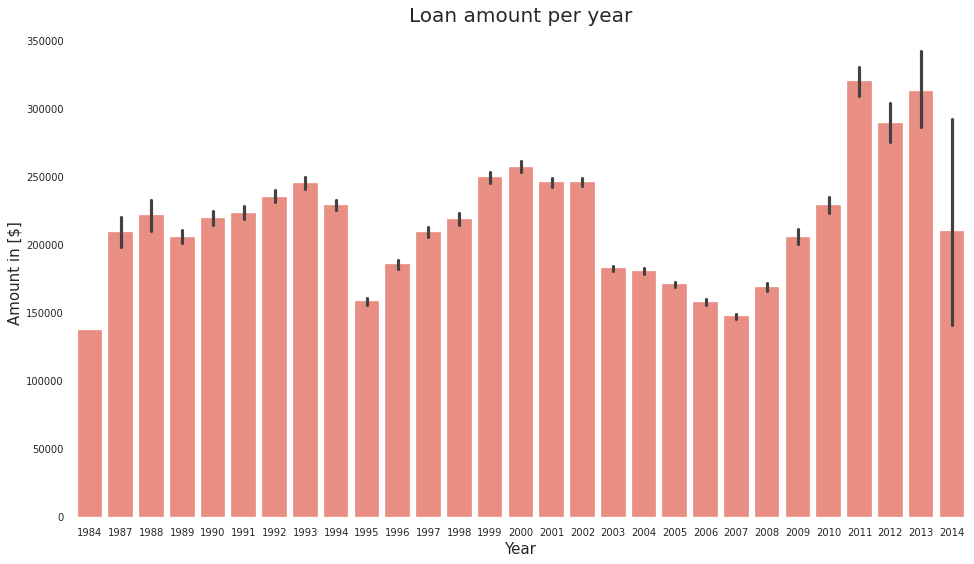


count    6.736500e+05
mean     1.964891e+05
std      2.976105e+05
min      4.000000e+03
25%      3.726600e+04
50%      9.200000e+04
75%      2.200000e+05
max      1.144632e+07
Name: DisbursementGross, dtype: float64



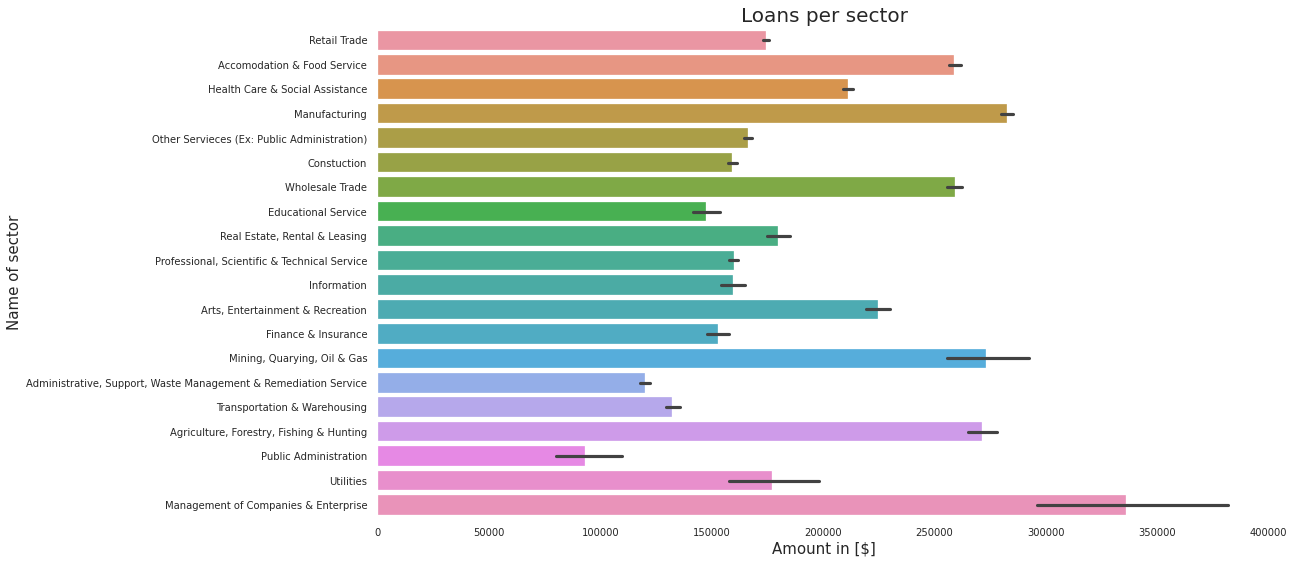

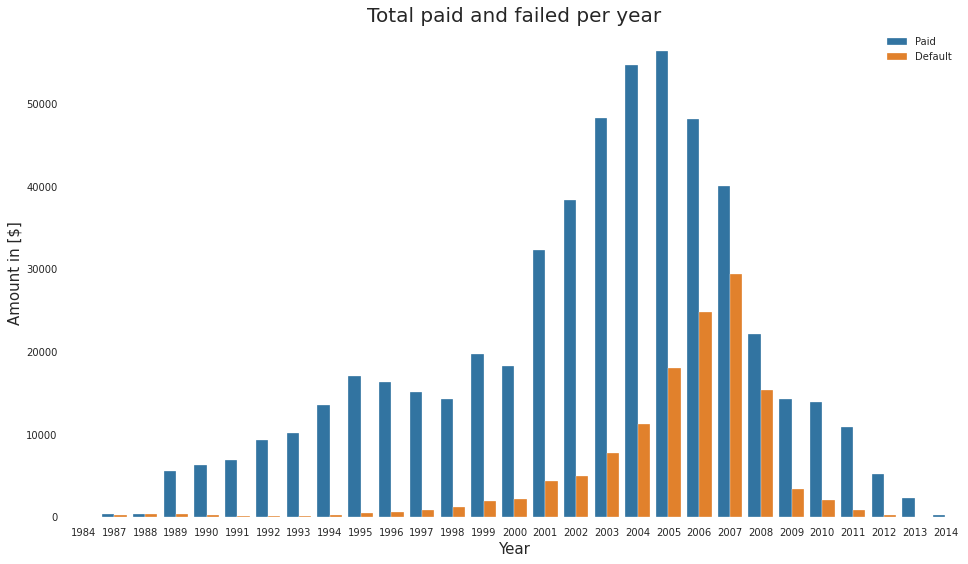

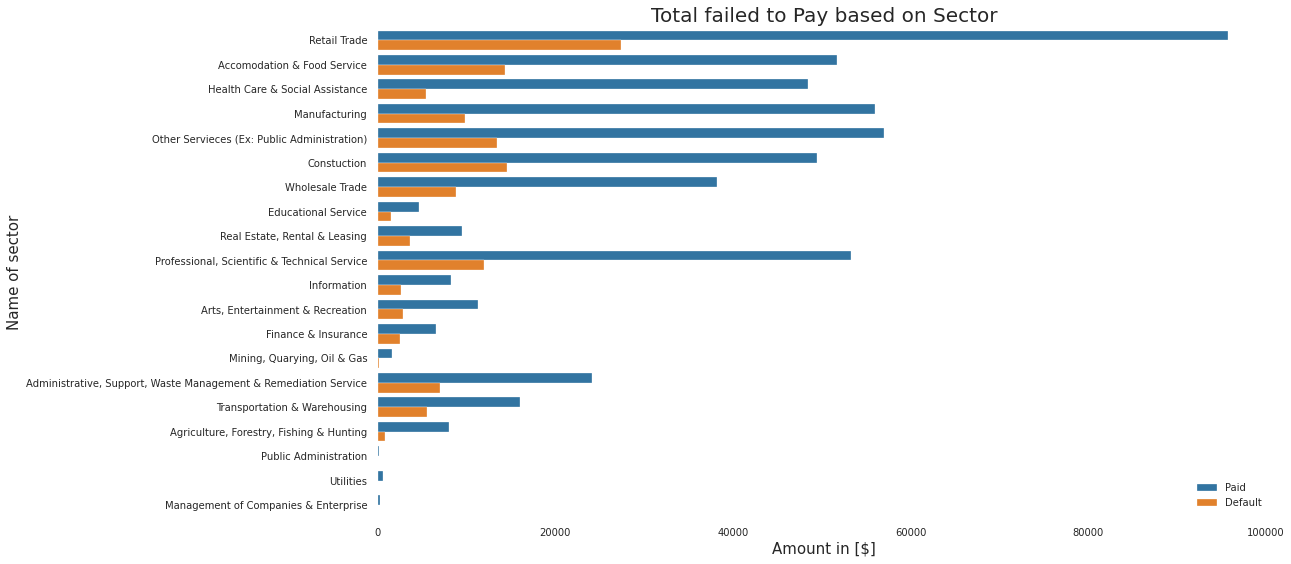

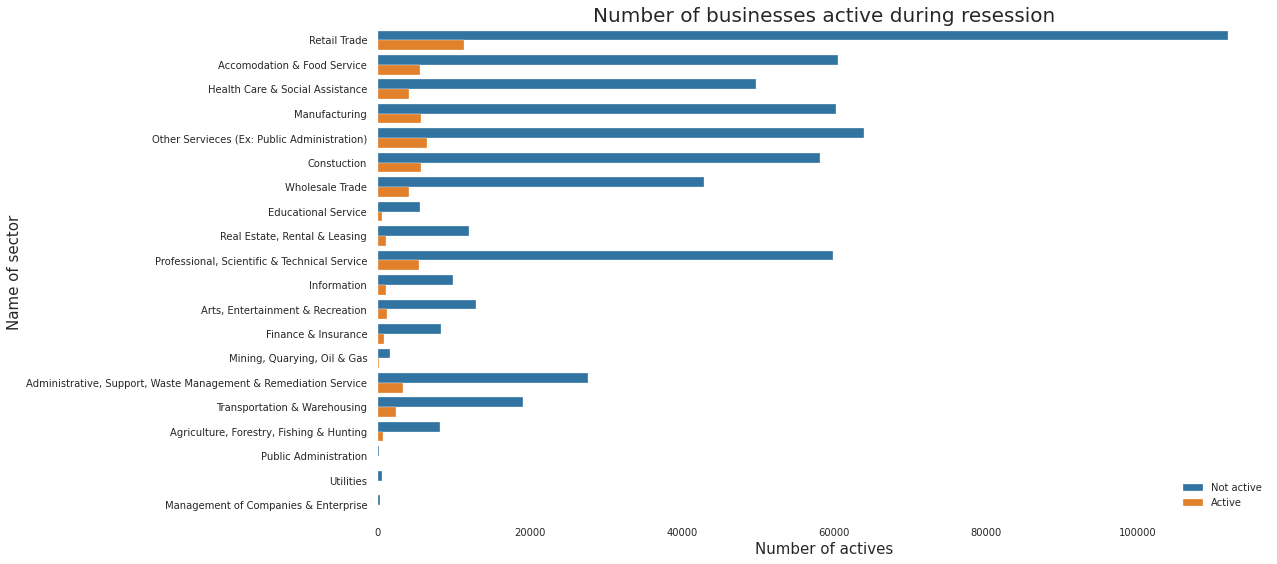

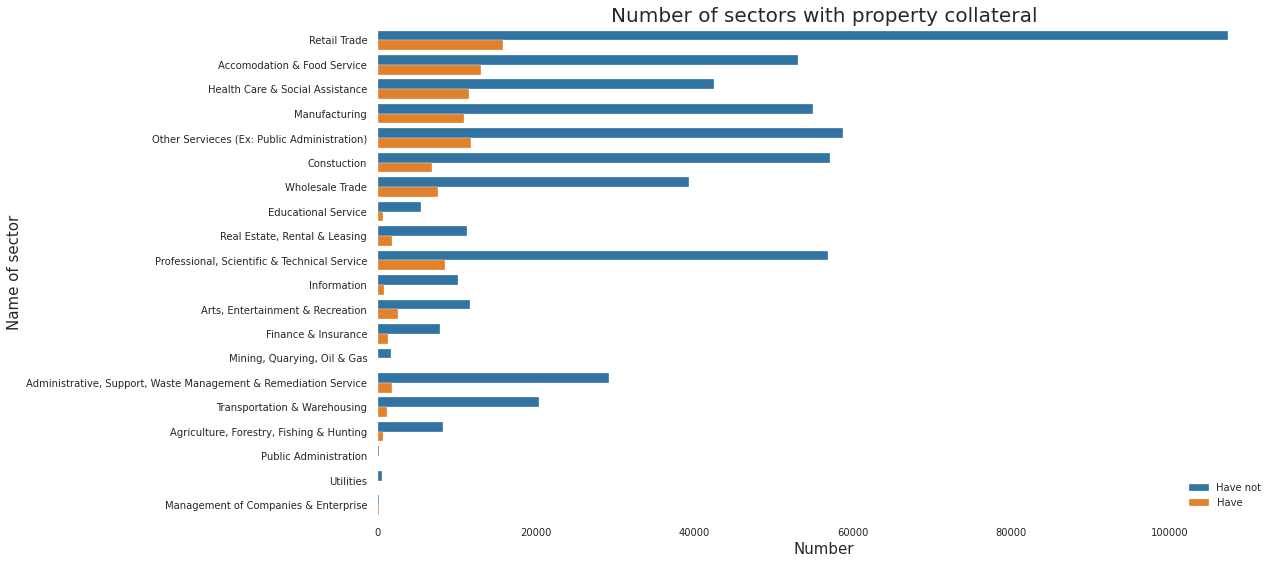

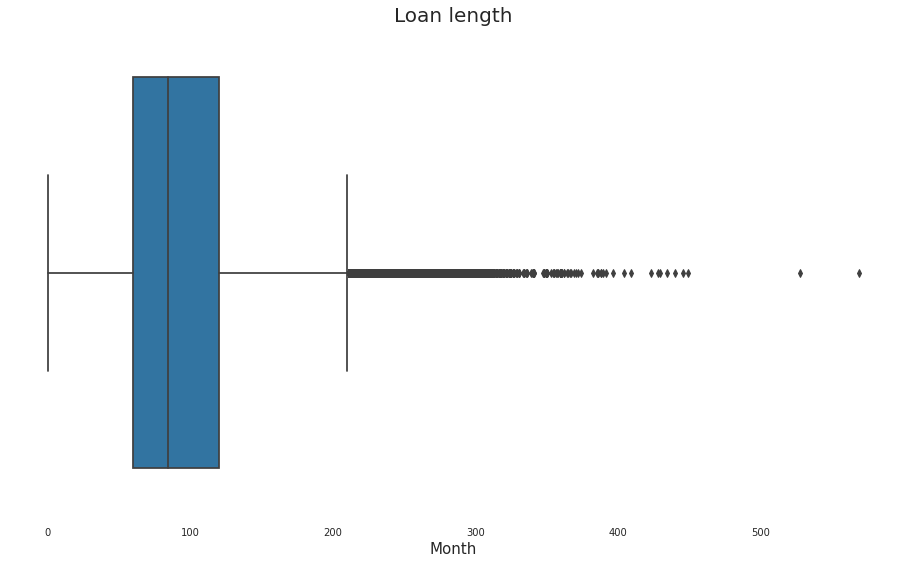

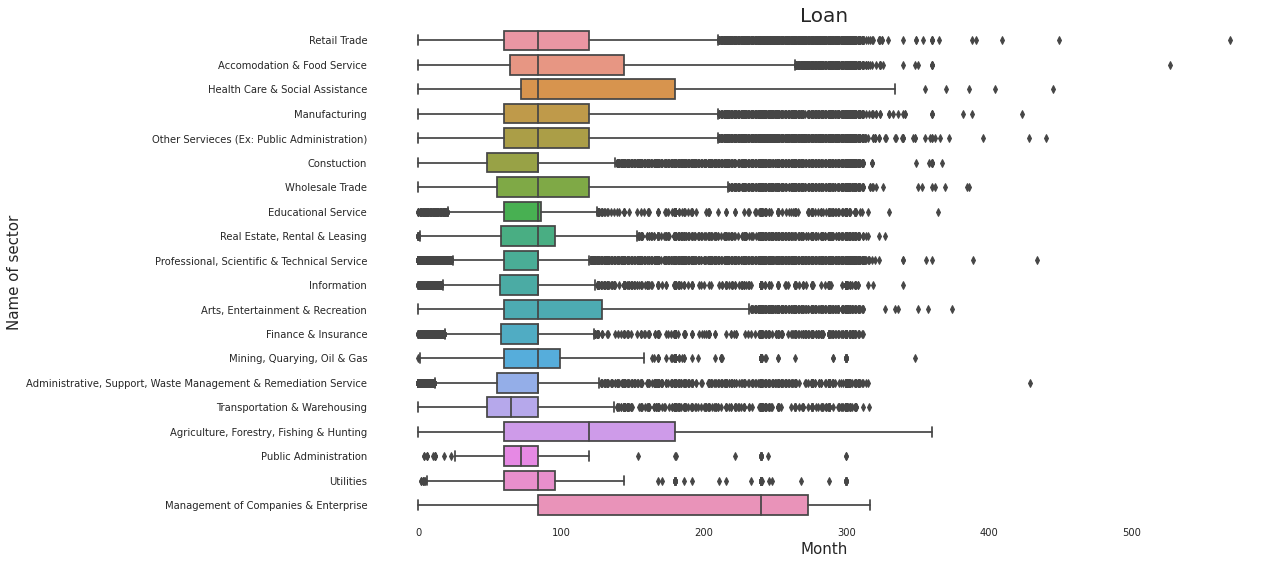

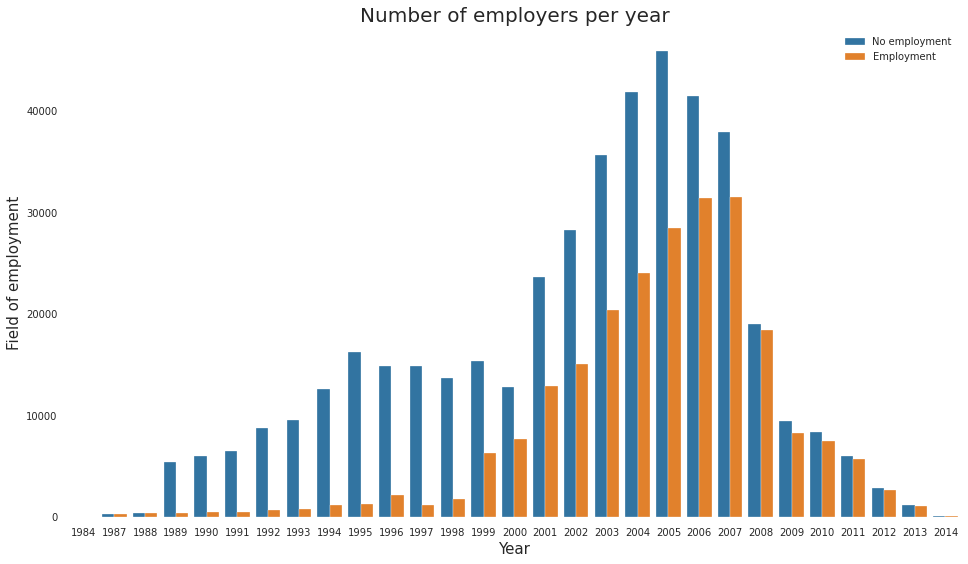

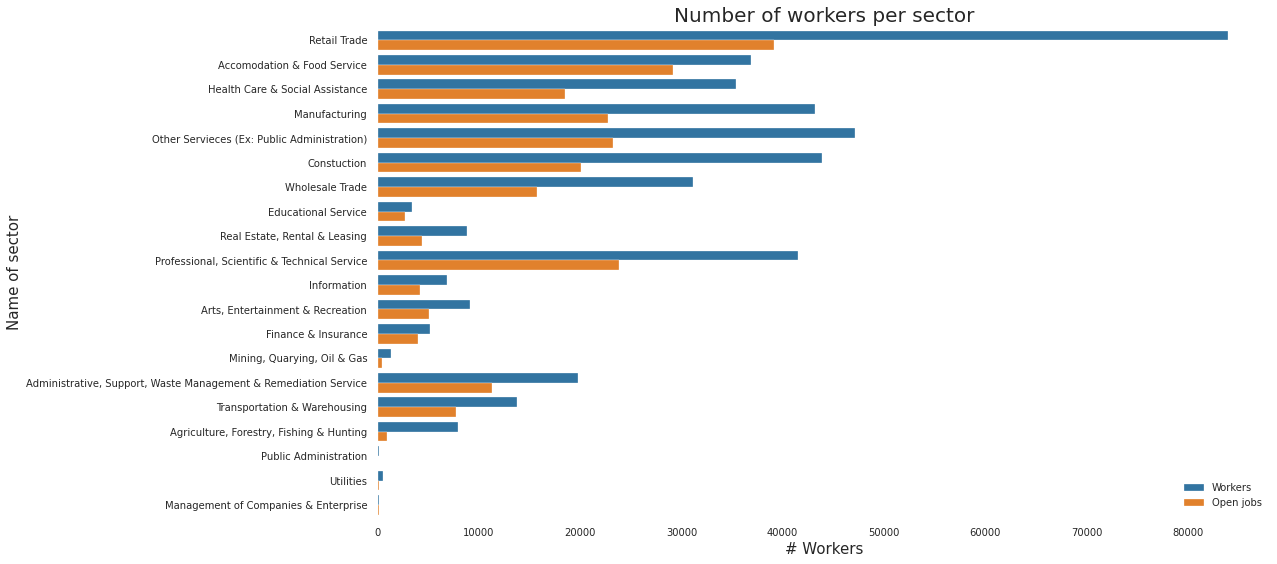

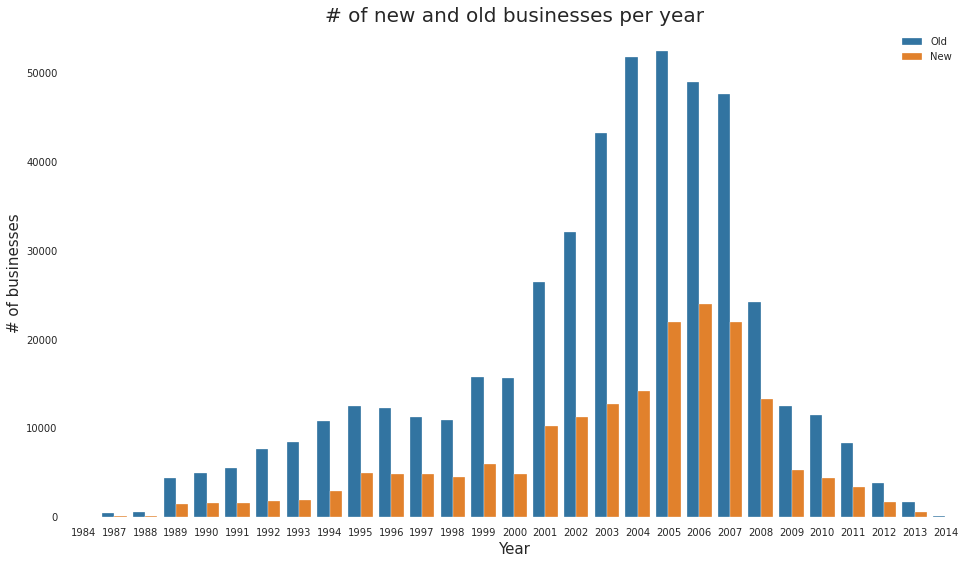

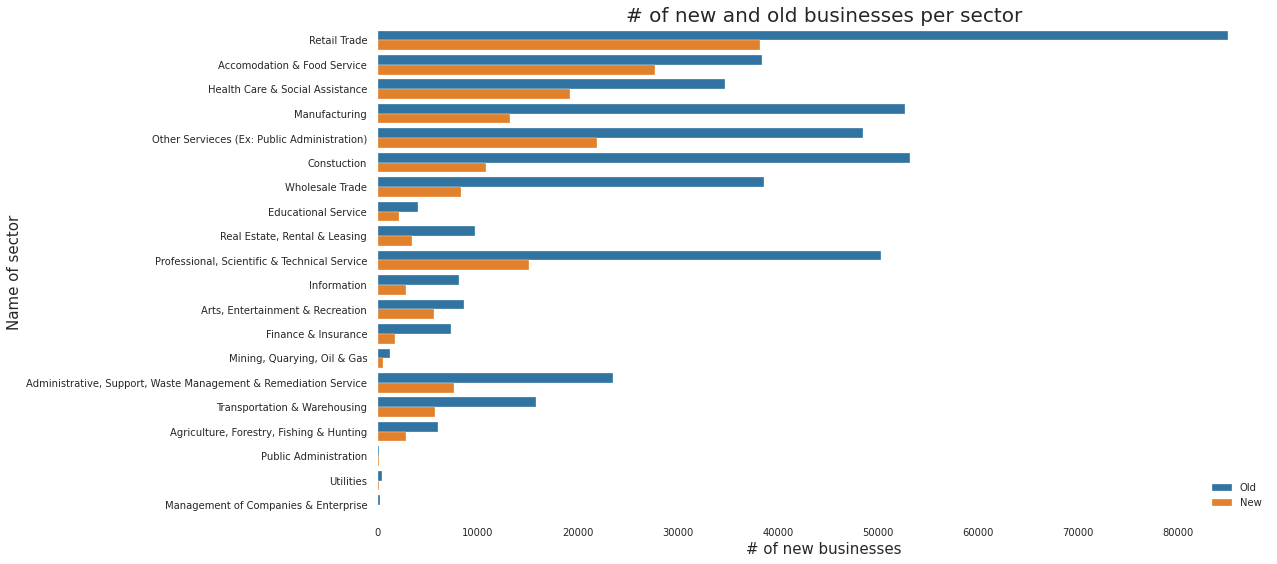

In [409]:
def sba_data_explore(df):
    """
    DATA EXPLORATION
    """

    # Adjust data types
    df = df.astype({'UrbanRural': 'object', 
                        'RevLineCr': 'int64', 
                        'LowDoc':'int64', 
                        'MIS_Status':'int64'})

    # Plot the loan amount per year
    plt.subplots(figsize=(16,9))
    sns.barplot(x="ApprovalFY", y="DisbursementGross", color='Salmon', data=df)
    plt.title('Loan amount per year', fontsize=20)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Amount in [$]', fontsize=15)
    plt.show()

    print()
    print(df.DisbursementGross.describe())
    print()

    # Plot of Loan amount per sector
    plt.subplots(figsize=(16,9))
    sns.barplot(x="DisbursementGross", y="Sector_name", data=df)
    plt.title('Loans per sector', fontsize=20)
    plt.xlabel('Amount in [$]', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.show()

    # Details of Loan amount per sector
    # df.groupby('Sector_name')['DisbursementGross'].describe().style.highlight_max(color='yellow').highlight_min(color='salmon')

    # Plot of paid and defaulted loans per year
    plt.subplots(figsize=(16,9))
    sns.countplot(x="ApprovalFY", data=df,hue='MIS_Status')
    plt.title('Total paid and failed per year', fontsize=20)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Amount in [$]', fontsize=15)
    plt.legend(['Paid', 'Default'],loc='upper right')
    plt.show()

    # Plot of paid and defaulted loans per year per sector
    plt.subplots(figsize=(16,9))
    sns.countplot(y="Sector_name", hue="MIS_Status", data=df)
    plt.title('Total failed to Pay based on Sector', fontsize=20)
    plt.xlabel('Amount in [$]', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.legend(["Paid", "Default"],loc='lower right')
    plt.show()

    # Details of paid and defaulted loans per year per sector
    # pd.DataFrame(df.groupby('Sector_name')['MIS_Status'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='salmon')

    # Plot of businesses active during the recession
    plt.subplots(figsize=(16,9))
    sns.countplot(y="Sector_name", hue="Recession", data=df)
    plt.title('Number of businesses active during resession', fontsize=20)
    plt.xlabel('Number of actives', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.legend(["Not active", "Active"],loc='lower right')
    plt.show()

    # Plot of sectors with property as collateral
    plt.subplots(figsize=(16,9))
    sns.countplot(y="Sector_name", hue="RealEstate", data=df)
    plt.title('Number of sectors with property collateral', fontsize=20)
    plt.xlabel('Number', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.legend(["Have not", "Have"],loc='lower right')
    plt.show()

    # Details for sectors with collateral
    # pd.DataFrame(df.groupby('Sector_name')['RealEstate'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='salmon')

    # Length of loans
    plt.subplots(figsize=(16,9))
    sns.boxplot(df['Term'])
    plt.title('Loan length', fontsize=20)
    plt.xlabel('Month', fontsize=15)
    plt.show()

    # Details of loan
    # df['Term'].describe()

    # Plot of loans per sector
    plt.subplots(figsize=(16,9))
    sns.boxplot(x="Term", y="Sector_name", data=df)
    plt.title('Loan', fontsize=20)
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.show()

    # Details for loans per sector
    # df.groupby('Sector_name')['Term'].describe().style.highlight_max(color='yellow').highlight_min(color='salmon')

    # Plot of fields with jobs per year
    plt.subplots(figsize=(16,9))
    sns.countplot(x="ApprovalFY", data=df,hue='Is_CreatedJob')
    plt.title('Number of employers per year', fontsize=20)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Field of employment', fontsize=15)
    plt.legend(['No employment', 'Employment'],loc='upper right')
    plt.show()

    # Plot of total employment per sector
    plt.subplots(figsize=(16,9))
    sns.countplot(y="Sector_name", hue="Is_CreatedJob", data=df)
    plt.title('Number of workers per sector', fontsize=20)
    plt.xlabel('# Workers', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.legend(['Workers', 'Open jobs'],loc='lower right')
    plt.show()

    # Details for field of employment
    # pd.DataFrame(df.groupby('Sector_name')['Is_CreatedJob'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='salmon')

    # Plot of new and old businesses in SBA per year
    plt.subplots(figsize=(16,9))
    sns.countplot(x="ApprovalFY", data=df,hue='NewExist')
    plt.title('# of new and old businesses per year', fontsize=20)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('# of businesses', fontsize=15)
    plt.legend(["Old", "New"],loc='upper right')
    plt.show()

    # Plot of number of new and old businesses per sector
    plt.subplots(figsize=(16,9))
    sns.countplot(y="Sector_name", hue="NewExist", data=df)
    plt.title('# of new and old businesses per sector', fontsize=20)
    plt.xlabel('# of new businesses', fontsize=15)
    plt.ylabel('Name of sector', fontsize=15)
    plt.legend(['Old', 'New'],loc='lower right')
    plt.show()

    # Details for new and old businesses per sector
    # pd.DataFrame(df.groupby('Sector_name')['NewExist'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='salmon')
    
sba_data_explore(df)

In [410]:
# Some highlights
df.groupby('Sector_name')['DisbursementGross'].describe().style.highlight_max(color='chartreuse').highlight_min(color='salmon')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accomodation & Food Service,66090,258902,367589,4000,50000,129000,285500,5e+06
"Administrative, Support, Waste Management & Remediation Service",31105,120083,211873,4000,25000,50000,125000,5.14886e+06
"Agriculture, Forestry, Fishing & Hunting",8847,271231,313844,4000,55000,160000,382000,3.35e+06
"Arts, Entertainment & Recreation",14201,224541,324011,4000,36000,100000,257000,4.42649e+06
Constuction,63959,159243,246365,4000,35000,75000,175000,5.65812e+06
Educational Service,6161,147451,253308,4000,25000,52359,150000,2.653e+06
Finance & Insurance,9127,152915,250600,4000,30000,66097,150000,4.7115e+06
Health Care & Social Assistance,53877,211122,283272,4000,50000,105000,250000,5e+06
Information,10957,159470,278165,4024,25000,58461,150000,5e+06


In [411]:
pd.DataFrame(df.groupby('Sector_name')['MIS_Status'].value_counts()).unstack(level=1).style.highlight_max(color='chartreuse').highlight_min(color='salmon')

In [412]:
# More detail for sectors with collateral
pd.DataFrame(df.groupby('Sector_name')['RealEstate'].value_counts()).unstack(level=1).style.highlight_max(color='chartreuse').highlight_min(color='salmon')

In [413]:
# Details of loan
df['Term'].describe()

count    673650.000000
mean        103.607029
std          75.105834
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

In [414]:
# Details for loans per sector
df.groupby('Sector_name')['Term'].describe().style.highlight_max(color='chartreuse').highlight_min(color='salmon')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accomodation & Food Service,66090,120.242,79.7974,0,64,84,144,527
"Administrative, Support, Waste Management & Remediation Service",31105,81.43,54.9891,0,55,84,84,429
"Agriculture, Forestry, Fishing & Hunting",8847,117.274,66.6468,0,60,120,180,360
"Arts, Entertainment & Recreation",14201,114.152,76.959,0,60,84,129,374
Constuction,63959,87.7255,70.5682,0,48,84,84,367
Educational Service,6161,94.7887,67.7917,0,60,84,86,364
Finance & Insurance,9127,97.3453,74.3485,0,58,84,84,312
Health Care & Social Assistance,53877,123.903,81.8906,0,72,84,180,445
Information,10957,84.8977,59.8225,0,57,84,84,340


In [415]:
# Details for field of employment
pd.DataFrame(df.groupby('Sector_name')['Is_CreatedJob'].value_counts()).unstack(level=1).style.highlight_max(color='chartreuse').highlight_min(color='salmon')

In [416]:
# Details for new and old businesses per sector
pd.DataFrame(df.groupby('Sector_name')['NewExist'].value_counts()).unstack(level=1).style.highlight_max(color='chartreuse').highlight_min(color='salmon')

Outlier analysis of DisbursementGross
Lower Limit: -236835.0
Lower Limit Extreme: -510936.0
Upper Limit: 494101.0
Upper Limit Extreme: 768202.0
Lower Limit: 100.0 %
Lower Limit Extreme: 100.0 %
Upper Limit: 10.527870555926668 %
Upper Limit Extreme: 5.0637571439174645 %
Outlier analysis of DisbursementGross
Lower Limit: 7.8625174164666465
Lower Limit Extreme: 5.199198171145936
Upper Limit: 14.964702070655209
Upper Limit Extreme: 17.62802131597592
Lower Limit: 100.0 %
Lower Limit Extreme: 100.0 %
Upper Limit: 0.04052549543531507 %
Upper Limit Extreme: 0.0 %
Outlier analysis of GrAppv
Lower Limit: -225000.0
Lower Limit Extreme: -480000.0
Upper Limit: 455000.0
Upper Limit Extreme: 710000.0
Lower Limit: 100.0 %
Lower Limit Extreme: 100.0 %
Upper Limit: 10.96335153182161 %
Upper Limit Extreme: 5.717671940069744 %
Outlier analysis of GrAppv
Lower Limit: 7.463272683315471
Lower Limit Extreme: 4.617592705986649
Upper Limit: 15.051752622858995
Upper Limit Extreme: 17.89743260018782
Lower Limit: 

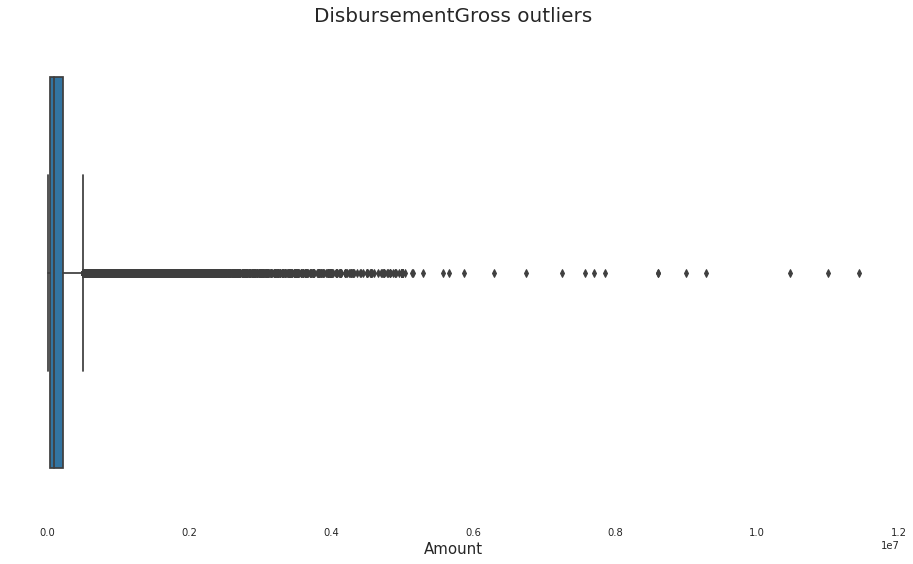

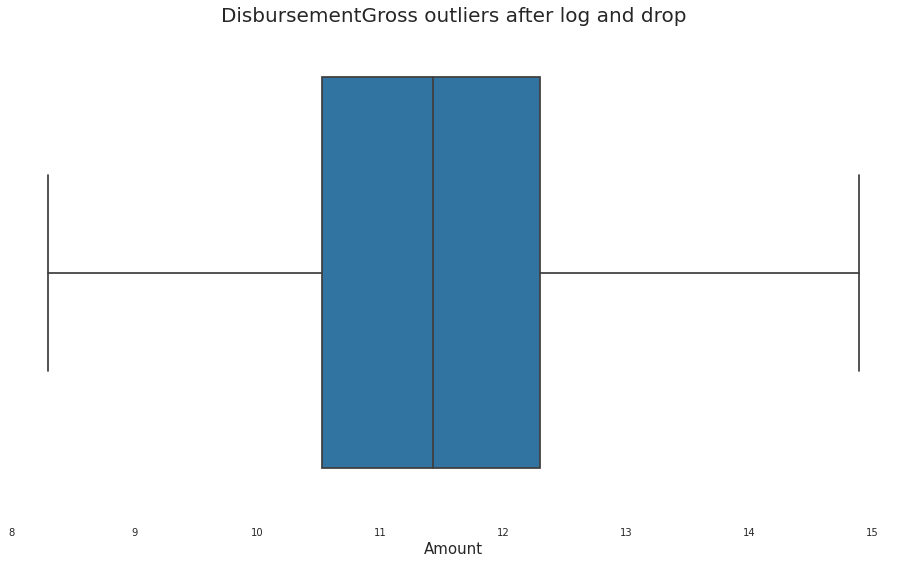

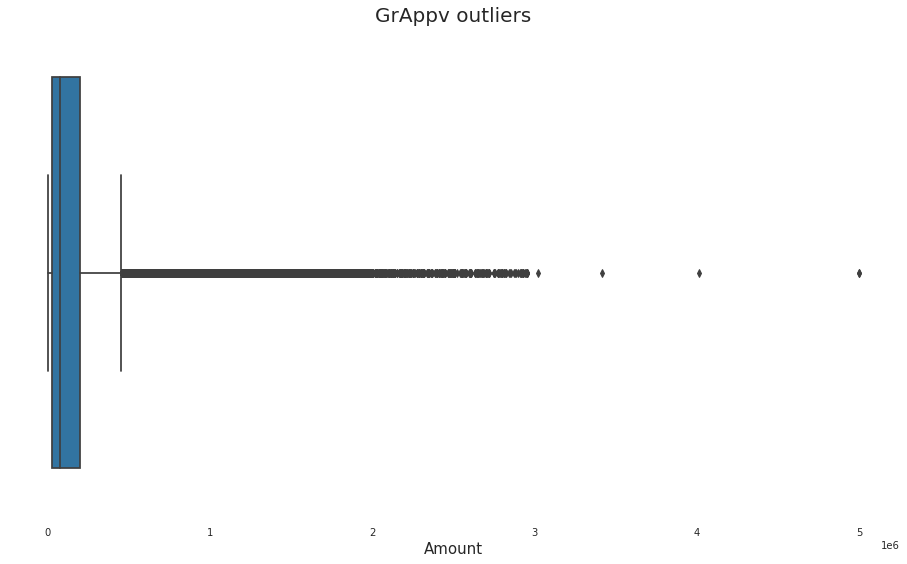

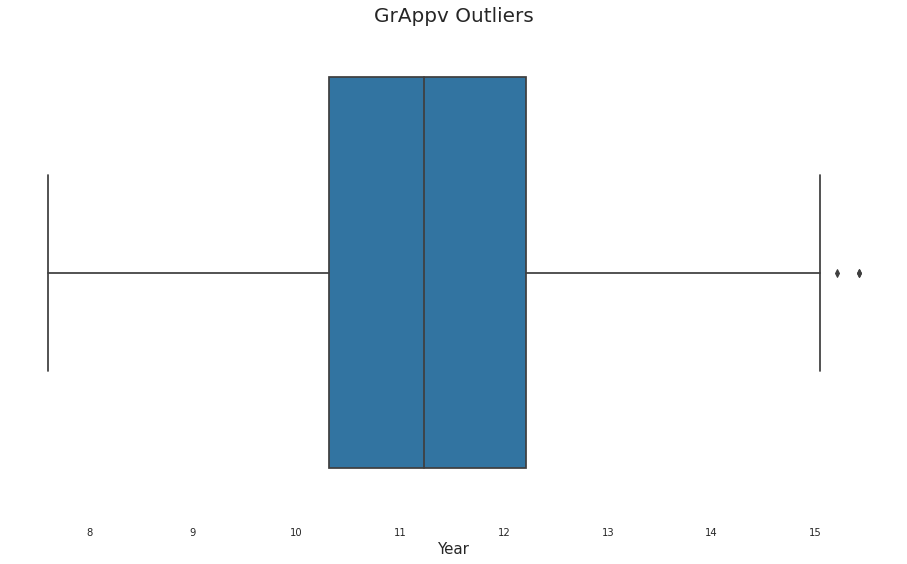

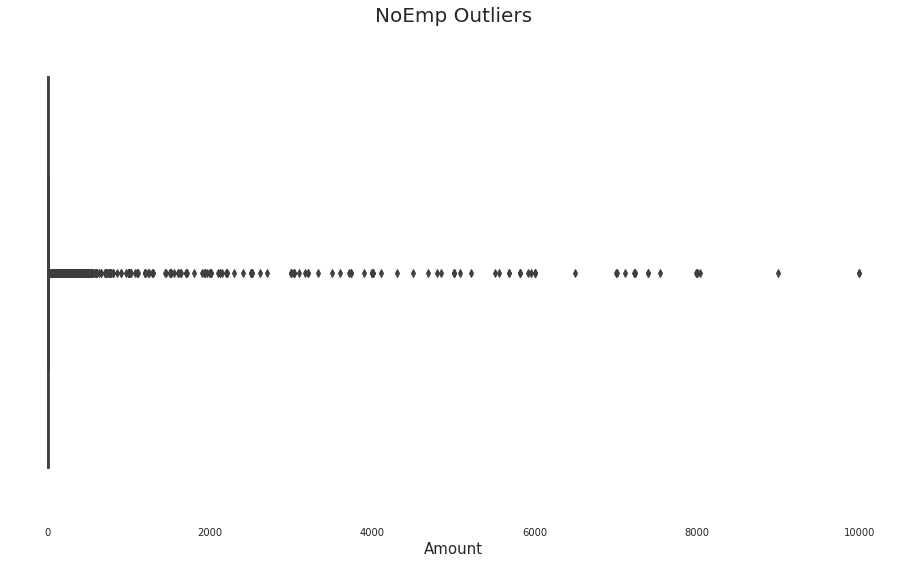

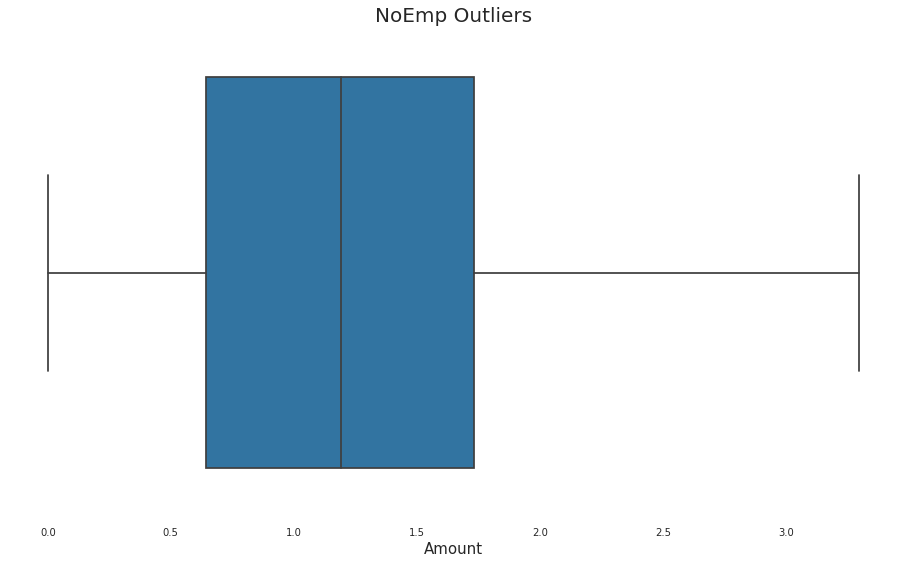

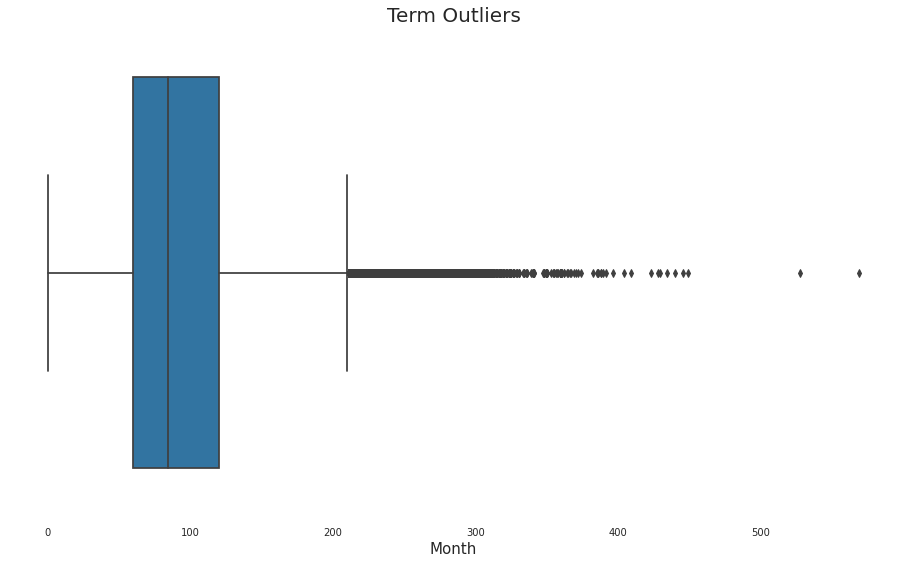

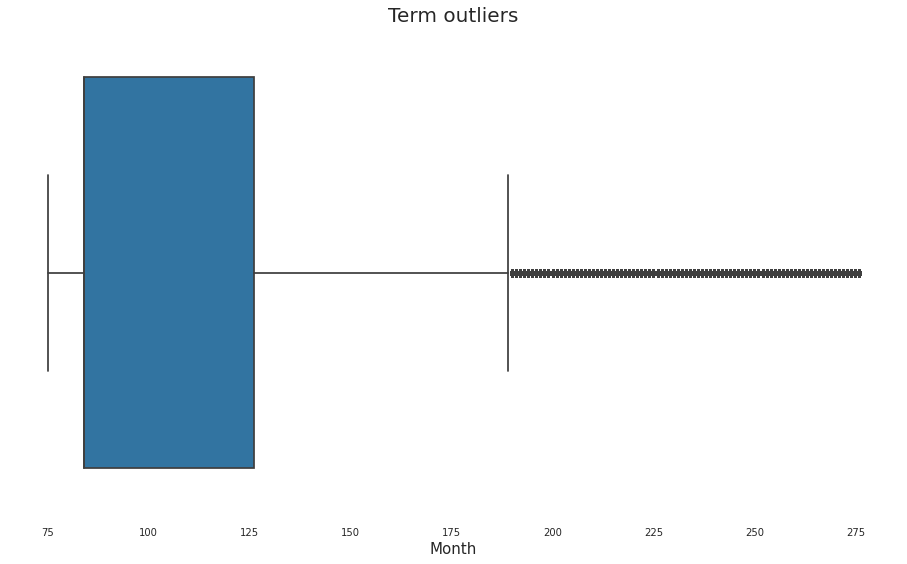

In [417]:
"""
OUTLIERS
"""

# Discard non-important columns:
# LoanNr_ChkDgt: dropped because the id of the borrower has been replaced by the index
# City, State, UrbanRural, ZIP: dropped since we changed to state rates
# bank: dropped because irrelevant
# NAICS: replaced with Sector_rate
# ApprovalDate, ApprovalFY: These are only recording dates
# Term: replaced by RealEstate
# UrbanRural: does not affect target
# LowDoc: irrelevant because of Gross Disbursement
# Active, DaysTerm: Replaced by recession
# ind_code: equal to Sector_rate
# ChgOffDate: equivalent to MIS_Status
# DisbursementDate: only payment dependent
# SBA_Appv: replaced by Portion_SBA_Bank
# DisbursementDate: No longer used
# Sector_name: no longer used
df = df.drop(axis =1, columns = ['LoanNr_ChkDgt','City','State', 'Zip', 'UrbanRural', 'LowDoc',
                                    'ApprovalDate', 'ApprovalFY', 'SBA_Appv','DisbursementDate', 
                                     'Sector_name','BalanceGross', 'ChgOffPrinGr'])

def outlier_analysis(df: pd.DataFrame, col: str) -> None:
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    lower_limit = df[col].quantile(0.25) - (iqr * 1.5)
    lower_limit_ex = df[col].quantile(0.25) - (iqr * 3)
    upper_limit = df[col].quantile(0.75) + (iqr * 1.5)
    upper_limit_ex = df[col].quantile(0.75) + (iqr * 3)
    print('=' * 50)
    print(f'Outlier analysis of {col}')
    print('=' * 50)
    print(f'Lower Limit: {lower_limit}')
    print(f'Lower Limit Extreme: {lower_limit_ex}')
    print(f'Upper Limit: {upper_limit}')
    print(f'Upper Limit Extreme: {upper_limit_ex}')
    print('=' * 50)
    print(f'Lower Limit: '
          f'{df[(df[col] >= lower_limit)].shape[0] / df.shape[0] * 100} %')
    print(f'Lower Limit Extreme: '
          f'{df[(df[col] >= lower_limit_ex)].shape[0] / df.shape[0] * 100} %')
    print(f'Upper Limit: '
          f'{df[(df[col] >= upper_limit)].shape[0] / df.shape[0] * 100} %')
    print(f'Upper Limit Extreme: '
          f'{df[(df[col] >= upper_limit_ex)].shape[0] / df.shape[0] * 100} %')
    print('=' * 50)
    

plt.subplots(figsize=(16,9))
sns.boxplot(x=df['DisbursementGross'])
plt.title('DisbursementGross outliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)

# Check the limit of the outliers and percentage that exceeds the limit
outlier_analysis(df, 'DisbursementGross')

# We have a lot of outliers, so we use a log transformation
df['DisbursementGross'] = np.log(df['DisbursementGross'])
df['DisbursementGross'].skew()

# Check again
outlier_analysis(df, 'DisbursementGross')

# After the transformation, the outliers are ~ 1%, so we drop those
df.drop(df[(df['DisbursementGross'] > 14.9)].index, inplace=True)

# Second Plot of outliers
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['DisbursementGross'])
plt.title('DisbursementGross outliers after log and drop', fontsize=20)
plt.xlabel('Amount', fontsize=15)

# Plot of GrAppv outliers
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['GrAppv'])
plt.title('GrAppv outliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)

# Check the limit of the outliers and percentage that exceeds the limit
outlier_analysis(df, 'GrAppv')

# We have a lot of outliers, so we use a log transformation
df['GrAppv'] = np.log(df['GrAppv'])
df['GrAppv'].skew()

# Check again
outlier_analysis(df, 'GrAppv')

# After the transformation, the outliers are ~ 1%, so we drop those
df.drop(df[(df['GrAppv'] < 7.5)].index, inplace=True)

# Second Plot of GrAppv outliers
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['GrAppv'])
plt.title('GrAppv Outliers', fontsize=20)
plt.xlabel('Year', fontsize=15)

# Plot of NoEmp outliers
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['NoEmp'])
plt.title('NoEmp Outliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)

# Check the limit of the outliers and percentage that exceeds the limit
outlier_analysis(df, 'NoEmp')

# In NoEmp is some input 0, we consider this an error
# wrong_input = df[(df['NoEmp'] == 0)].index
df.drop(df[(df['NoEmp'] == 0)].index, inplace=True)
# After trying other transformations, we settle on boxcox
df['NoEmp']= stats.boxcox(df['NoEmp'])[0]
df['NoEmp'].skew()

# Check the limit of the outliers and percentage that exceeds the limit
outlier_analysis(df, 'NoEmp')
# We drop the remaining 0.02% outliers
df.drop(df[(df['NoEmp'] > 3.3)].index, inplace=True)

# Plot of outliers in NoEmp
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['NoEmp'])
plt.title('NoEmp Outliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)

# Plot of outliers in Term
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['Term'])
plt.title('Term Outliers', fontsize=20)
plt.xlabel('Month', fontsize=15)

# We have some data that is longer than the underlying timespan from
# 1987–2010, so we set a minimum of 75 months and a maximum of 276 months
df.drop(df[(df['Term'] < 75)].index, inplace=True)
df.drop(df[(df['Term'] > 276)].index, inplace=True)

# Plot of outliers in Term
plt.subplots(figsize=(16,9))
sns.boxplot(x=df['Term'])
plt.title('Term outliers', fontsize=20)
plt.xlabel('Month', fontsize=15)

# Check the limit of the outliers and percentage that exceeds the limit
outlier_analysis(df, 'Term')

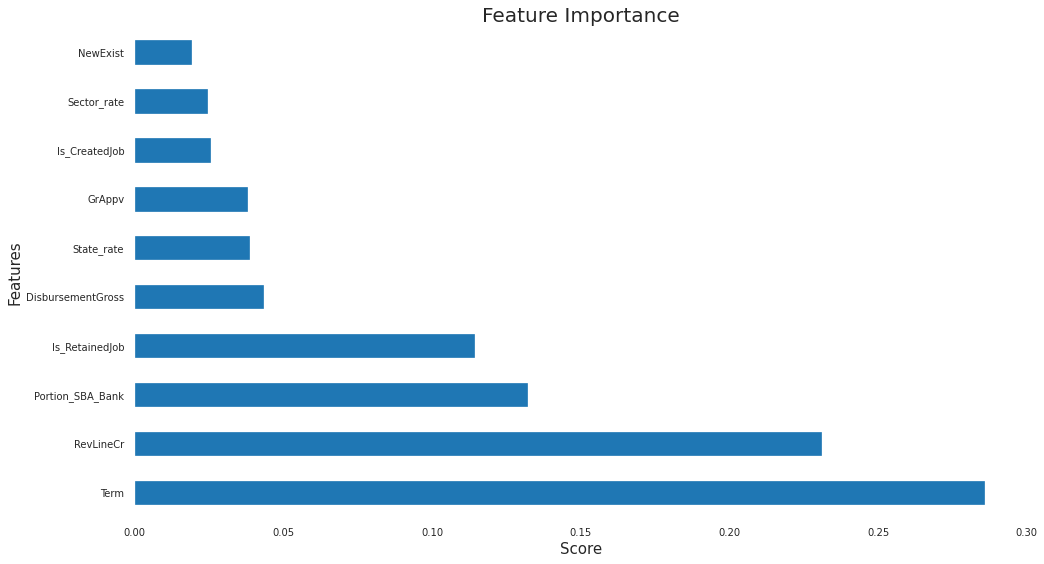

In [418]:
"""
FEATURE SELECTION
"""
# We have a huge number of inputs, so we need to classify the features
#data = data.reset_index(drop=True) # reset index so that it is sorted
y = df['MIS_Status']
X = df.drop(columns=['MIS_Status'], axis=1)

# Importance feature of XGBoost
model = XGBClassifier()
model.fit(X,y)

# Visualize important features
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.subplots(figsize=(16,9))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.show()

In [419]:
# Based on the feature selection above, we will select these features and discard the
# features that are not relevant to the target
df = df[['RevLineCr', 'Term', 'Portion_SBA_Bank', 'GrAppv', 'State_rate', 'DisbursementGross',
            'Is_RetainedJob', 'Sector_rate', 'Recession', 'Is_CreatedJob', 'MIS_Status']]
df.shape

(389185, 11)

0    367460
1     21725
Name: MIS_Status, dtype: int64
MIS_Status (0): 94.41782185849917 %
MIS_Status (1): 5.582178141500829 %


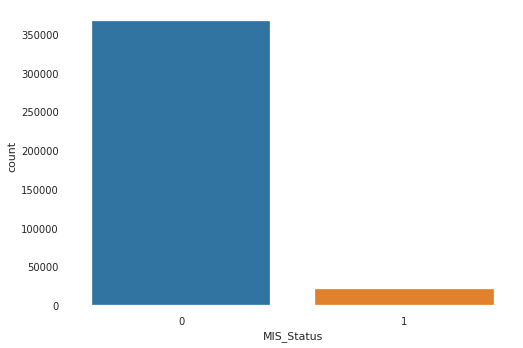

In [420]:
"""
IMBALANCED DATASET
"""
# Check the variable target ratio
print(df.MIS_Status.value_counts())
print('='*50)
print('MIS_Status (0): {} %'.format(df[(df['MIS_Status'] == 0)].shape[0]/df.shape[0]*100))
print('MIS_Status (1): {} %'.format(df[(df['MIS_Status'] == 1)].shape[0]/df.shape[0]*100))

# Plot of imbalance
sns.countplot("MIS_Status",data=df)

In [421]:
# it can be seen that our target variable is unbalanced: 
# 0 (not default): 94.3% and 1 (default): 5.7% 
# We will deal with this problem with undersampling
# Divide the data into train and test
y = df['MIS_Status']
X = df.drop(columns=['MIS_Status'], axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# We use SMOTE and undersampling
over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [422]:
# Functions for training and evaluation
def model_eval(algo, X_train, y_train, X_test, y_test):
    """
    CLASSIFICATION
    """
    algo.fit(X_train, y_train)
    # y_train_ypred = algo.predict(X_train)
    # y_train_prob = algo.predict_proba(X_train)[:, -1]

    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:, -1]
    y_probas = algo.predict_proba(X_test)

    plot_confusion_matrix(algo, X_test, y_test)
    plt.show()
    print('=' * 50)
    print('Classification Report:')
    print(classification_report(y_test, y_test_ypred, digits=3))
    print('=' * 50)

    # ROC Curve
    # fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    roc_curve(y_test, y_test_prob)
    skplt.metrics.plot_roc(y_test, y_probas, figsize=(16, 9))

    # PR Curve
    skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(16, 9))
    plt.show()

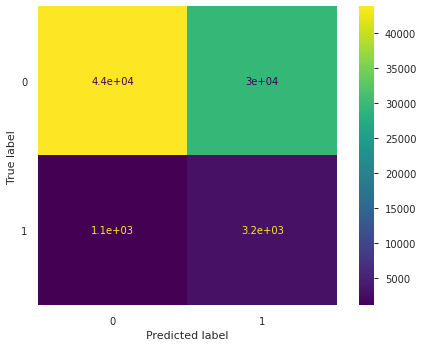

Classification Report:
              precision    recall  f1-score   support

           0      0.975     0.597     0.740     73492
           1      0.097     0.736     0.172      4345

    accuracy                          0.604     77837
   macro avg      0.536     0.666     0.456     77837
weighted avg      0.926     0.604     0.708     77837



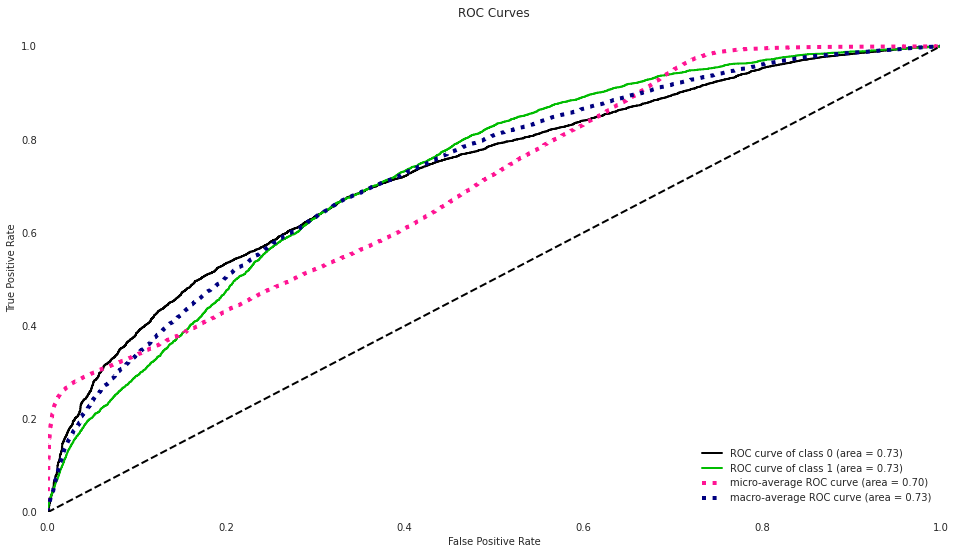

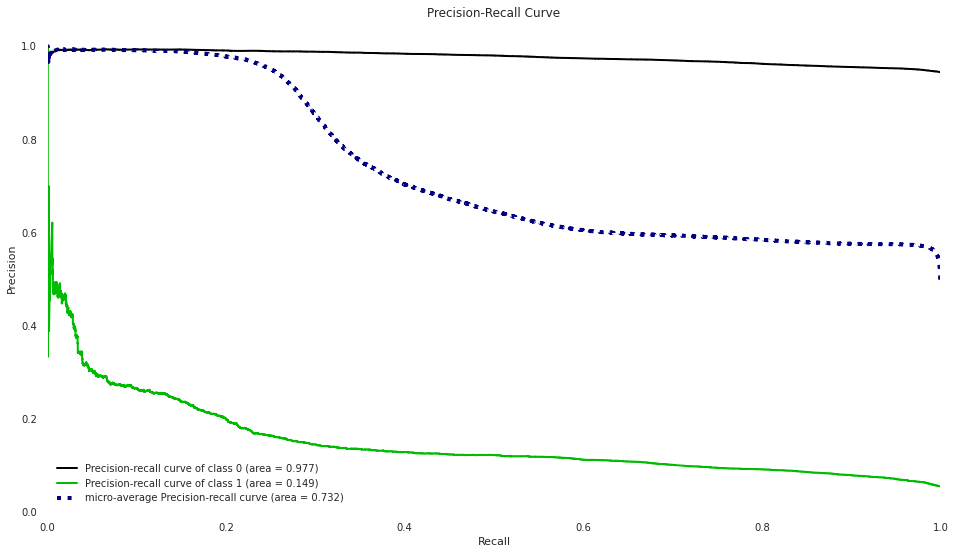

In [423]:
# Logistic Regression
model_eval(LogisticRegression(),X_train,y_train,X_test,y_test)

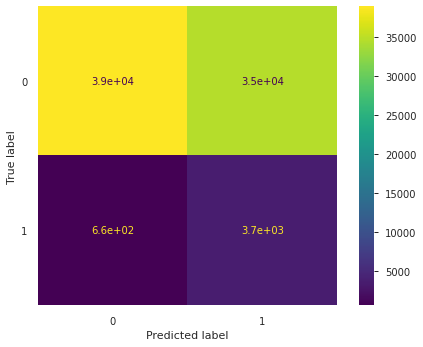

Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.529     0.688     73492
           1      0.096     0.849     0.173      4345

    accuracy                          0.547     77837
   macro avg      0.540     0.689     0.431     77837
weighted avg      0.934     0.547     0.659     77837



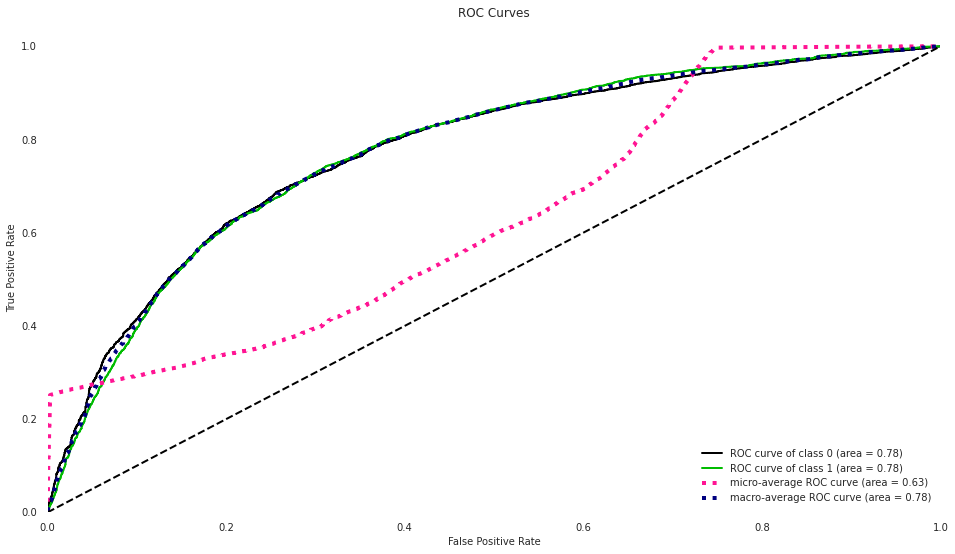

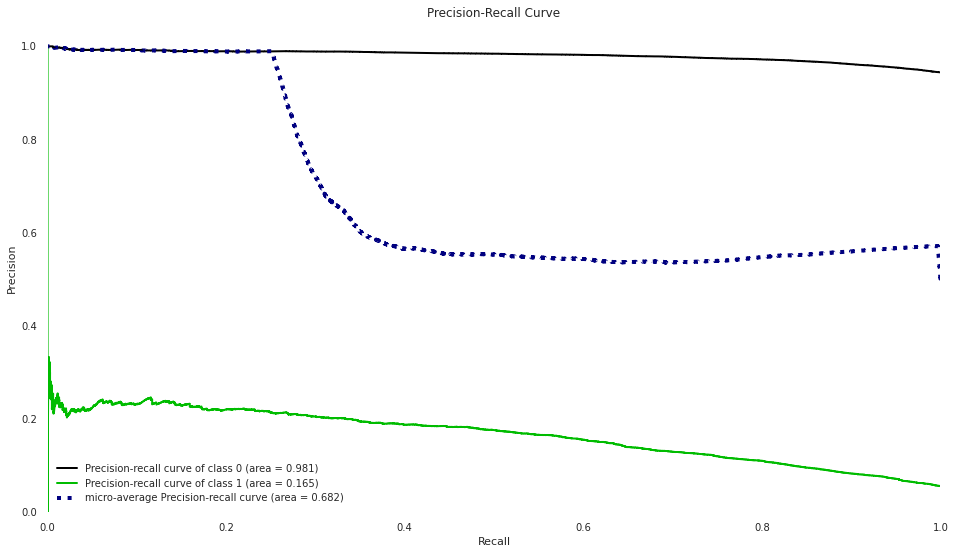

In [424]:
# Naive Bayes
model_eval(GaussianNB(),X_train,y_train,X_test,y_test)

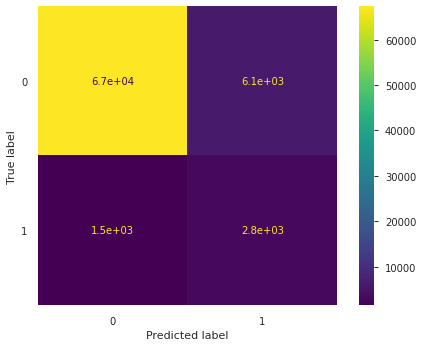

Classification Report:
              precision    recall  f1-score   support

           0      0.978     0.916     0.946     73492
           1      0.316     0.654     0.426      4345

    accuracy                          0.902     77837
   macro avg      0.647     0.785     0.686     77837
weighted avg      0.941     0.902     0.917     77837



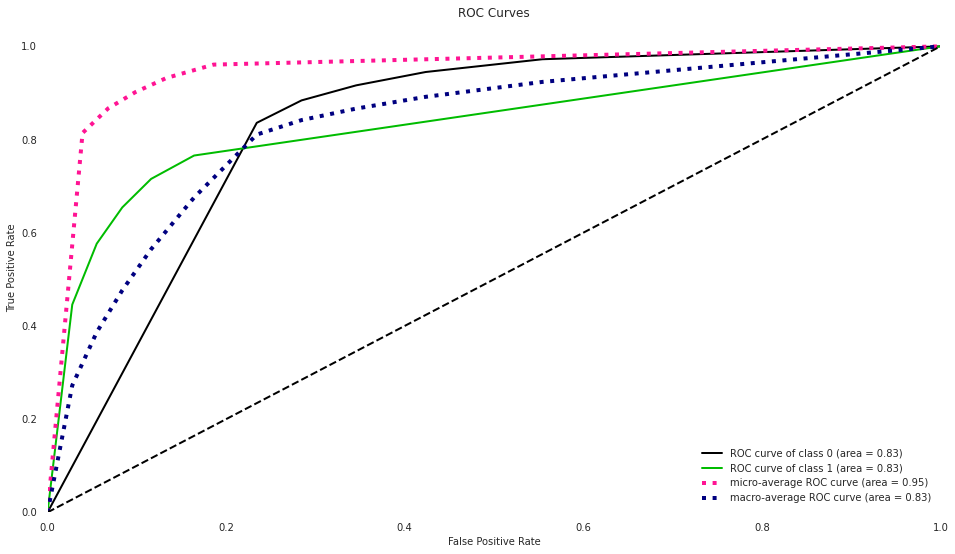

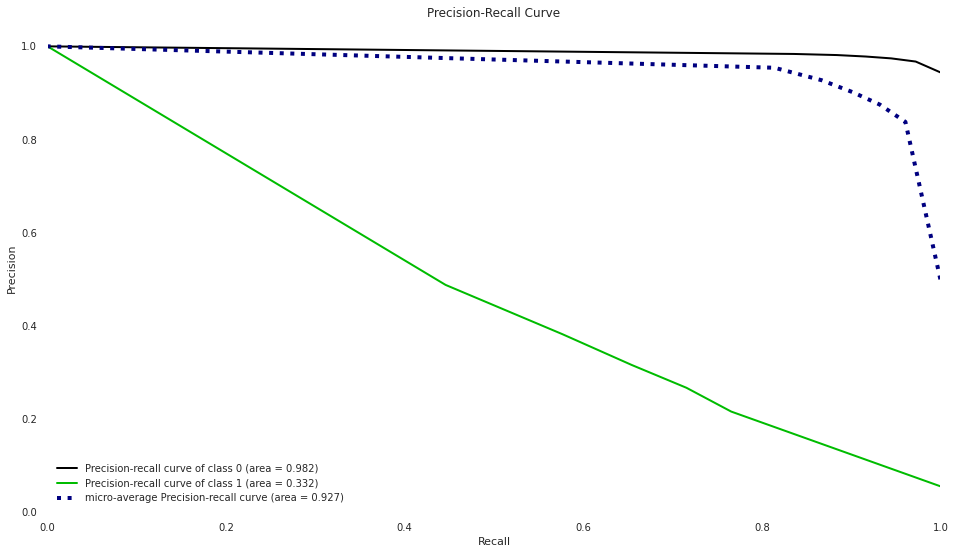

In [425]:
# KNN
model_eval(KNeighborsClassifier(),X_train,y_train,X_test,y_test)

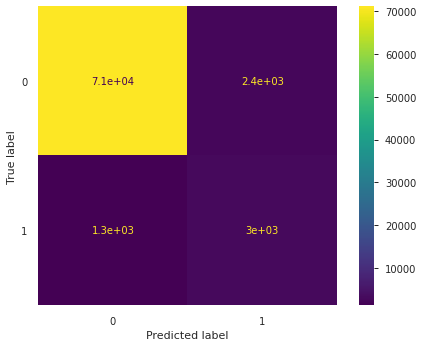

Classification Report:
              precision    recall  f1-score   support

           0      0.982     0.967     0.974     73492
           1      0.554     0.694     0.616      4345

    accuracy                          0.952     77837
   macro avg      0.768     0.831     0.795     77837
weighted avg      0.958     0.952     0.954     77837



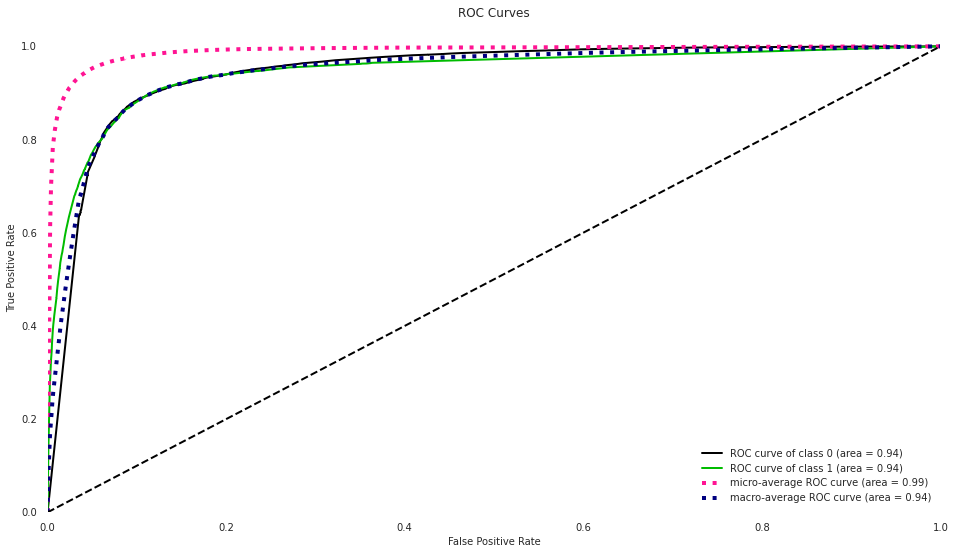

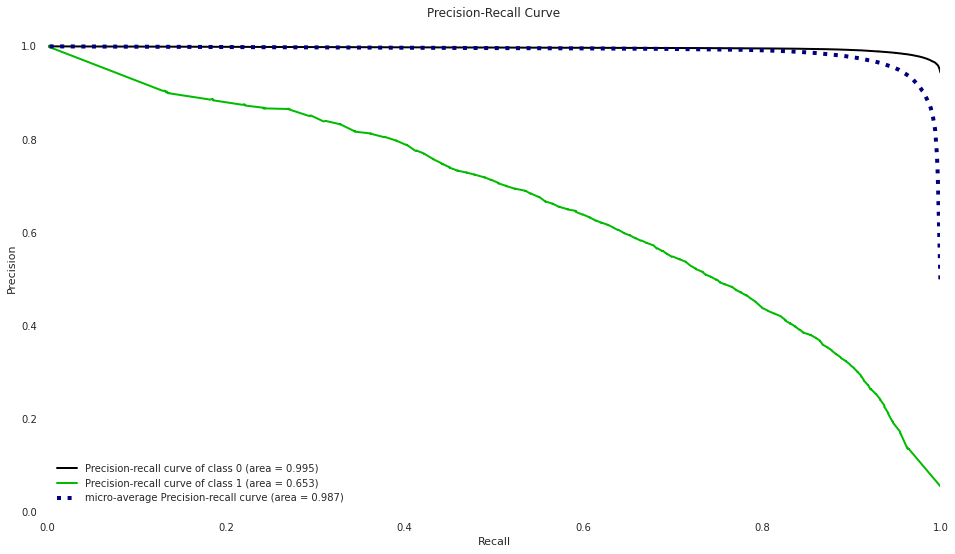

In [426]:
# Random Forest
model_eval(RandomForestClassifier(),X_train,y_train,X_test,y_test)

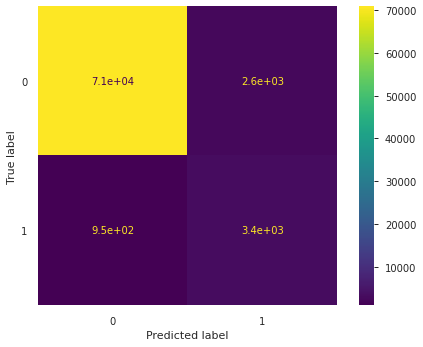

Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.965     0.976     73492
           1      0.571     0.782     0.660      4345

    accuracy                          0.955     77837
   macro avg      0.779     0.874     0.818     77837
weighted avg      0.964     0.955     0.958     77837



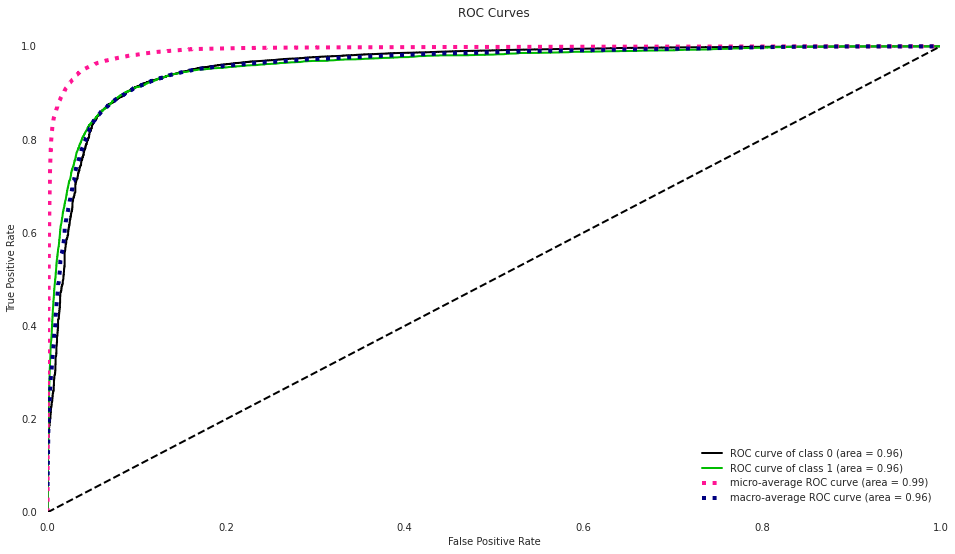

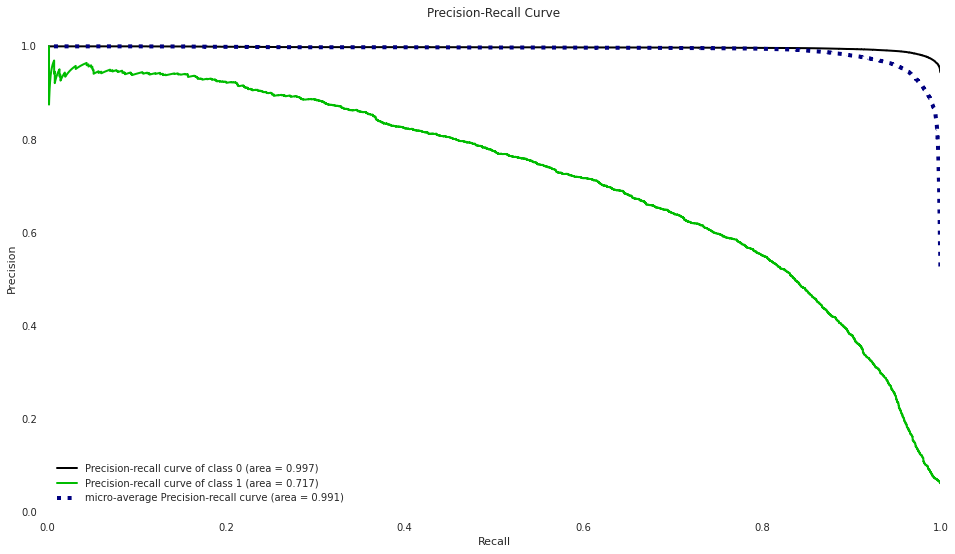

In [427]:
# XGBoost
model_eval(XGBClassifier(),X_train,y_train,X_test,y_test)

In [428]:
def model_opt(clf, params, x_train, y_train, x_test, y_test):
    # The optimization function with GridSearchCV
    """
    MODEL TUNING
    We conclude that XGBoost is the best model but can also see that the performance of 
    neither Precision nor Recall is great, so we use the f-1 Score to optimize.
    """


    search = GridSearchCV(estimator=clf,
                          param_grid=params,
                          scoring='f1',
                          n_jobs=-1,
                          cv=3,
                          verbose=True)

    search.fit(x_train, y_train)
    best = search.best_estimator_
    best_model = best.fit(x_train, y_train)

    y_test_ypred = best_model.predict(x_test)
    y_test_prob = best_model.predict_proba(x_test)[:, -1]
    y_probas = best_model.predict_proba(x_test)

    print('Best parameters: \n', search.best_params_)
    print('=' * 50)
    
    # Confusion Matrix
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('=' * 50)
    print('Classification Report: \n',
          classification_report(y_test, y_test_ypred, digits=3))
    print('=' * 50)
    
    # ROC + PR Curves
    fpr,tpr,thresholds = roc_curve(y_test,y_test_prob)
    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9) )
    skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(16,9))
    plt.show()

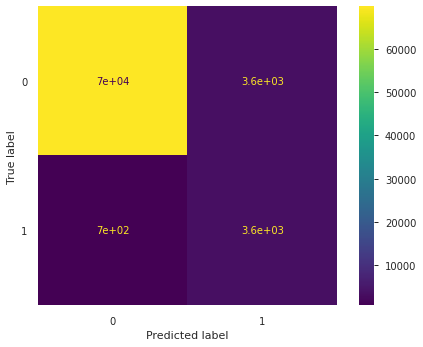

Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.951     0.970     73492
           1      0.501     0.838     0.627      4345

    accuracy                          0.944     77837
   macro avg      0.746     0.894     0.799     77837
weighted avg      0.963     0.944     0.951     77837



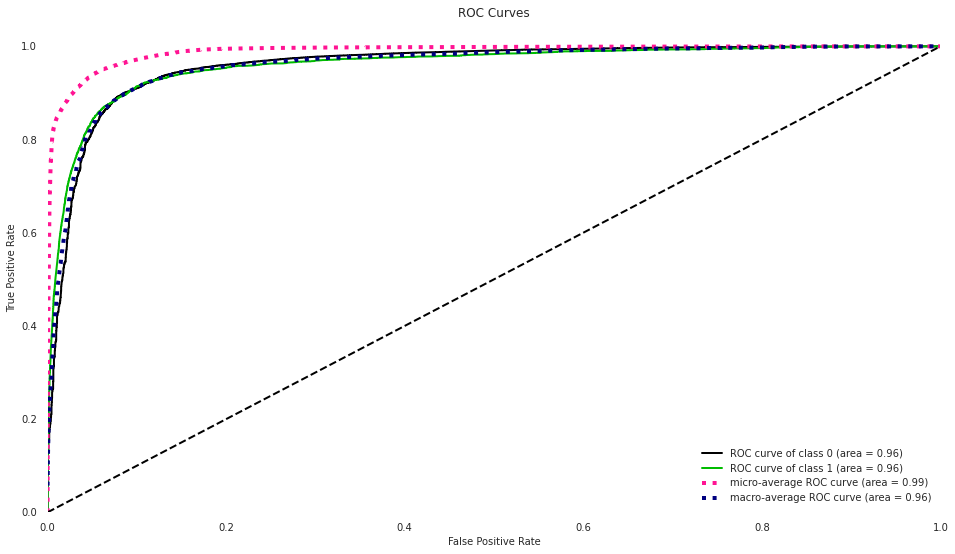

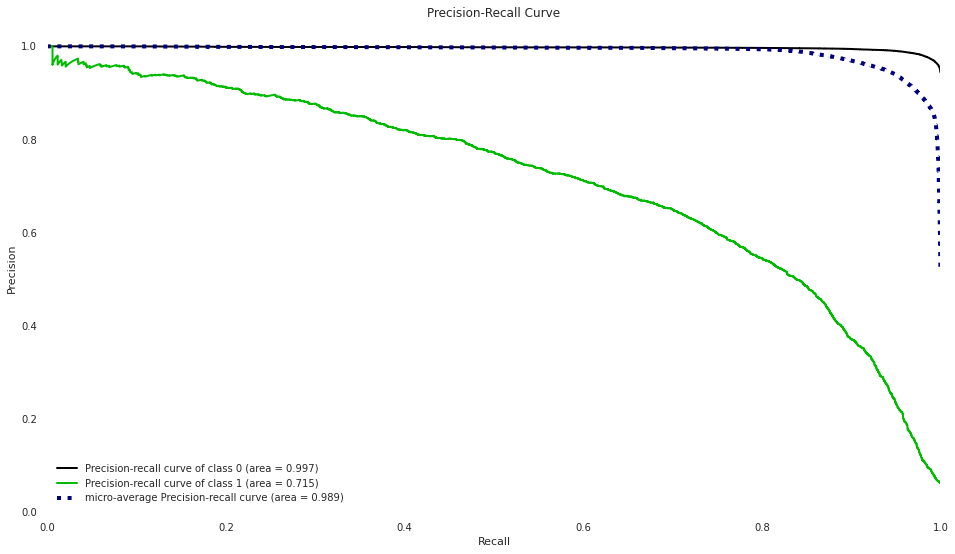

'\nSUMMARY\n\nThere are several conclusions that can be drawn from this project:\n\nThe best model is XGBoost with \nMicro Average PR AUC 98.9%, Recall 85.1%, Precision 51% and the following tuning:\ncolsample_bytree: 0.5,\ngamma: 0.0,\nlearning_rate: 0.15,\nmax_depth: 6,\nmin_child_weight: 1\nVariables that are relevant or affect the target are:\nTerm\nRevLineCr\nPortion_SBA_Bank\nIs_RetainedJob\nDisbursementGross\nState_rate\nGrAppv\nRecession\nSector_rate\n'

In [429]:
params = {"learning_rate"   : [0.05, 0.10, 0.15],
              "max_depth"       : [3, 4, 5, 6],
              "min_child_weight": [1, 3, 5, 7],
              "gamma"           : [0.0, 0.1, 0.2],
              "colsample_bytree": [0.3, 0.4, 0.5]}

# GridSearchCV gives us optimal parameters:
{'colsample_bytree': 0.5,
 'gamma'           : 0.0,
 'learning_rate'   : 0.15,
 'max_depth'       : 6, 'min_child_weight': 1}

# Use of the optimized parameters
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=0.5, gamma=0.0,
                    learning_rate=0.15, max_delta_step=0, max_depth=6,
                    min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1,
                    nthread=None, objective='binary:logistic',
                    random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                    seed=None,
                    silent=None, subsample=1, verbosity=1)

model_eval(xgb, X_train, y_train, X_test, y_test)

"""
There is a slight increase compared to the previous 79.5% Recall, now 85.1%. 
Since there will be a trade-off between recall and precision we use Scoring on GridSearchCV 
because it will try to harmonize the two. 
Keep in mind that this dataset is highly unbalanced to the target variable.
"""

"""
SUMMARY

There are several conclusions that can be drawn from this project:

The best model is XGBoost with 
Micro Average PR AUC 98.9%, Recall 85.1%, Precision 51% and the following tuning:
colsample_bytree: 0.5,
gamma: 0.0,
learning_rate: 0.15,
max_depth: 6,
min_child_weight: 1
Variables that are relevant or affect the target are:
Term
RevLineCr
Portion_SBA_Bank
Is_RetainedJob
DisbursementGross
State_rate
GrAppv
Recession
Sector_rate
"""